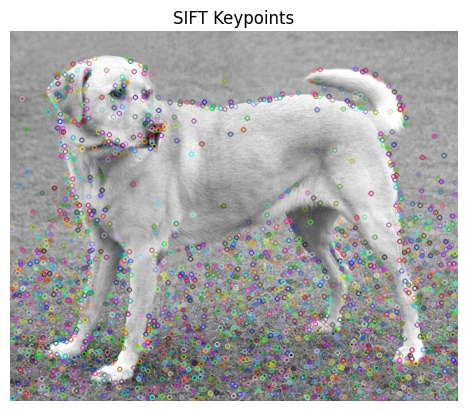

In [1]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('/content/sample_data/image_new.jpg', cv2.IMREAD_GRAYSCALE)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(image, None)
img_with_kp = cv2.drawKeypoints(image, keypoints, None)

plt.imshow(img_with_kp)
plt.title("SIFT Keypoints")
plt.axis('off')
plt.show()

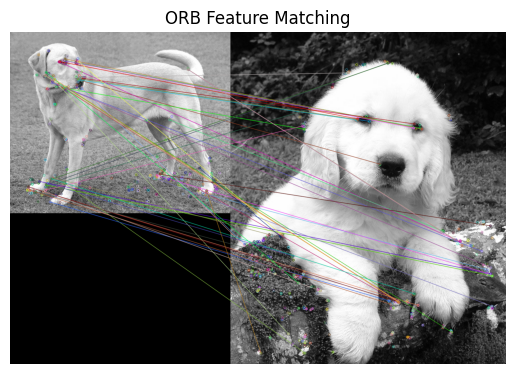

In [3]:
img1 = cv2.imread('/content/sample_data/image_new.jpg', 0)
img2 = cv2.imread('/content/sample_data/Golde33443.jpg', 0)

orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None)
plt.imshow(img_matches)
plt.title("ORB Feature Matching")
plt.axis('off')
plt.show()

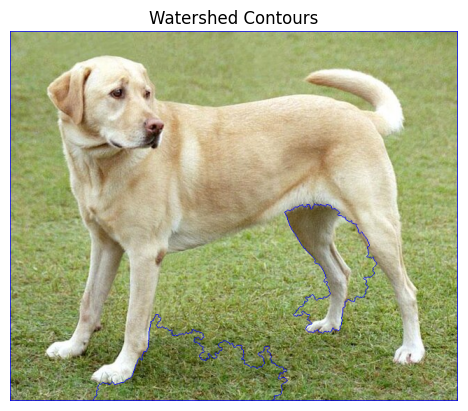

In [5]:
import numpy as np
image = cv2.imread('/content/sample_data/image_new.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Distance transform + markers
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, markers = cv2.connectedComponents(np.uint8(dist_transform > 0.7 * dist_transform.max()))

# Apply watershed
markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]  # Red boundaries

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Watershed Contours")
plt.axis('off')
plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1195 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1122 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Average PSNR on test set: 10.23 dB


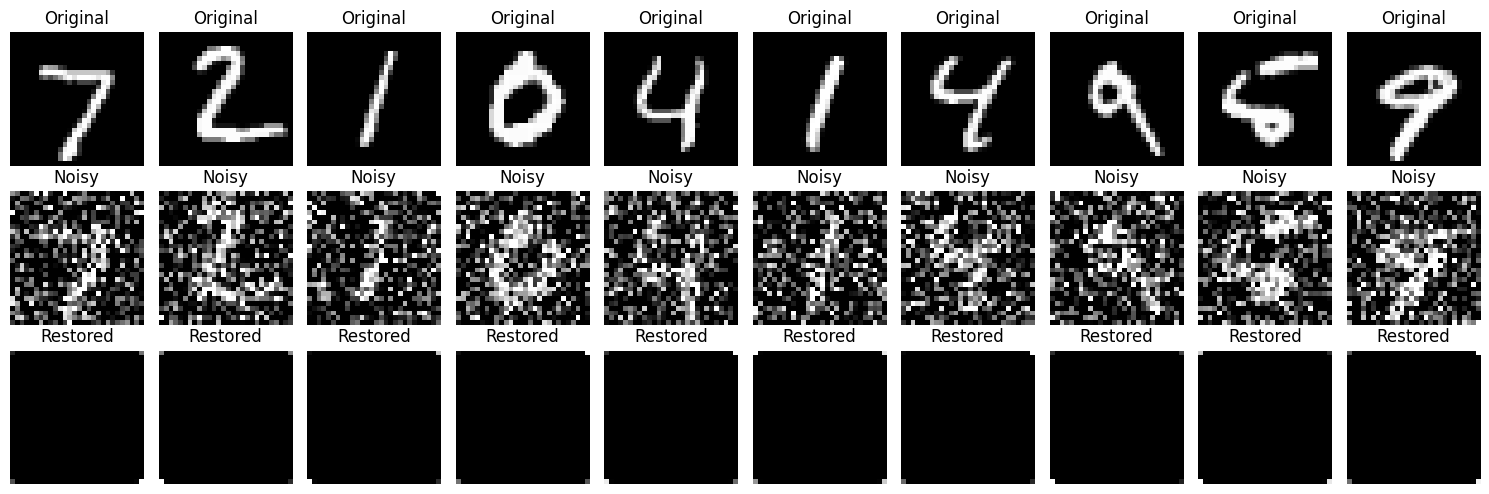

In [6]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from skimage.metrics import peak_signal_noise_ratio as psnr

# Step 1: Load & Preprocess Data
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize between [0, 1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# Reshape to (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Step 2: Simulate Degradation
def add_noise(imgs):
    noisy = imgs + np.random.normal(loc=0.0, scale=0.5, size=imgs.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy

def add_blur(imgs):
    return tf.nn.avg_pool2d(imgs, ksize=3, strides=1, padding='SAME').numpy()

x_train_noisy = add_noise(add_blur(x_train))
x_test_noisy = add_noise(add_blur(x_test))

# Step 3: Build the Autoencoder Model
def build_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded)

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

# Step 4: Train the Model
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=10,  # Change to 50 for full training
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))

# Step 5: Image Restoration & Evaluation
restored_imgs = autoencoder.predict(x_test_noisy)

# Evaluate using PSNR
psnr_values = [psnr(x_test[i].squeeze(), restored_imgs[i].squeeze()) for i in range(100)]
print(f"Average PSNR on test set: {np.mean(psnr_values):.2f} dB")

# Compare original, noisy, and restored
n = 10
plt.figure(figsize=(15, 5))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Restored
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(restored_imgs[i].squeeze(), cmap='gray')
    plt.title("Restored")
    plt.axis('off')
plt.tight_layout()
plt.show()